# Read all the hap.py vcfs and compute overlaps

Needs an environment with pyvcf and other anaconda packages.

Because it needs pyvcf, the dependencies dictate that it will have an older version of seaborn and others.

In [1]:
import vcf
import vcf.utils
import glob
import re
import pandas as pd
import upsetplot
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

## Read metadata

In [2]:
paths = glob.glob("d50_variant_analysis/*/*vcf.gz")

In [3]:
names, kits, concs, replicates = zip(*[
    re.match(r".*/(([A-Za-z0-9]+)-(\d+ng)-(\d))\.vcf\.gz", path).groups()
    for path in paths
])

## Data frame for metadata summary

In [4]:
df = pd.DataFrame({'Name': names, 'Kit': kits, 'Conc': concs, 'Replicate': replicates, 'Path': paths})

In [5]:
df.head()

,Name,Kit,Conc,Replicate,Path
0,Kapa-10ng-2,Kapa,10ng,2,d50_variant_analysis/Kapa-10ng-2_happy/Kapa-10...
1,Kapa-100ng-2,Kapa,100ng,2,d50_variant_analysis/Kapa-100ng-2_happy/Kapa-1...
2,NEB-10ng-2,NEB,10ng,2,d50_variant_analysis/NEB-10ng-2_happy/NEB-10ng...
3,Swift2S-10ng-2,Swift2S,10ng,2,d50_variant_analysis/Swift2S-10ng-2_happy/Swif...
4,Swiftlong-10ng-1,Swiftlong,10ng,1,d50_variant_analysis/Swiftlong-10ng-1_happy/Sw...


### Only analyse 100 ng data

In [6]:
# af = analysis data frame
af = df[(df.Conc=='100ng')&(df.Kit!="Swiftlong")].copy()

In [7]:
kits = list(set(af.Kit))
print(kits)
print(kits[-10:])

['NEB', 'Nextera', 'Swift2S', 'Quanta', 'Kapa']
['NEB', 'Nextera', 'Swift2S', 'Quanta', 'Kapa']


### Find quality cut-offs for picking N true positives

In [9]:
# Nextera @ QQ>-5: 11269522
N = 3_000_000
N2 = 2_500_000
nbatch = 10000
q_cuts = []
q_n2 = []
i=0
for kit in kits:
    #break # Skip this loop -- computed values for normalisation mode "d" given below
    readers = [vcf.Reader(filename=path) for path in af[af.Kit==kit].Path]
    print("Analysing", len(readers), "files for kit", kit, ".")
    qvals = np.array([])
    ibatch = 0
    n_rows = 0
    batch = np.zeros(nbatch)
    for variants in vcf.utils.walk_together(*readers):
        n_rows += 1
        if any(var.samples[0].data.BVT == 'SNP' for var in variants if var):
            replicates_qvals = sorted([var.samples[1].data.QQ for var in variants
                     if var and var.samples[1].data.BD=='TP'])
            if len(replicates_qvals) > 2:
                batch[ibatch] = replicates_qvals[-3]
                ibatch += 1
                if ibatch == nbatch:
                    ii = np.searchsorted(qvals, batch)
                    qvals = np.insert(qvals, ii, batch)[-(N+1):]
                    ibatch = 0
    ii = np.searchsorted(qvals, batch[0:ibatch])
    qvals = np.insert(qvals, ii, batch[0:ibatch])[-(N+1):]
    print('Kit', kit, ' - Processed', n_rows, 'rows.')
    print('Kit', kit, 'QQ >', qvals[0], "(", len(qvals)-1, " variants)")
    q_cuts.append(qvals[0])
    if len(qvals) > N2+1:
        print('Kit', kit, 'QQ >', qvals[-(N2+1)], "(", N2, "variants)")
        q_n2.append(qvals[-(N2+1)])

Analysing 4 files for kit NEB .
Kit NEB  - Processed 5504887 rows.
Kit NEB QQ > -16.118 ( 2743262  variants)
Kit NEB QQ > -0.218 ( 2500000 variants)
Analysing 4 files for kit Nextera .
Kit Nextera  - Processed 5093068 rows.
Kit Nextera QQ > -16.118 ( 2701510  variants)
Kit Nextera QQ > 0.001 ( 2500000 variants)
Analysing 4 files for kit Swift2S .
Kit Swift2S  - Processed 5515923 rows.
Kit Swift2S QQ > -16.118 ( 2730591  variants)
Kit Swift2S QQ > -0.148 ( 2500000 variants)
Analysing 4 files for kit Quanta .
Kit Quanta  - Processed 5396280 rows.
Kit Quanta QQ > -16.118 ( 2724454  variants)
Kit Quanta QQ > -0.125 ( 2500000 variants)
Analysing 4 files for kit Kapa .
Kit Kapa  - Processed 5288817 rows.
Kit Kapa QQ > -16.118 ( 2717780  variants)
Kit Kapa QQ > -0.13 ( 2500000 variants)


In [10]:
#qq_cuts_dict = {}
#qq_cuts_dict['Kapa'] = -1.6
#qq_cuts_dict['NEB'] = -1.595
#qq_cuts_dict['Swift2S'] = -1.603
#qq_cuts_dict['Nextera'] = -2.308
#qq_cuts_dict['Quanta'] = -1.998
qq_cuts_dict = dict(zip(kits, q_cuts))

## Make a place to hold the counts

`group_combinations`

| Truth | Type  | Value |
|-------|-------|-------|
| True  | SNP   | Series counts |
| False | SNP   | Series counts |
| True  | INDEL | Series counts |
| False | INDEL | Series counts |

Series counts are series containing the counts of each combination of callers. The indexes are MultiIndexes with one level for each kit, with value True if the variant is called, False otherwise.

In [11]:
group_counts_idx = pd.MultiIndex.from_product([[True,False] for _ in kits], names=kits)
types = ['SNP', 'INDEL'] # May need to refactor if we're to separate indel types

In [12]:
kits

['NEB', 'Nextera', 'Swift2S', 'Quanta', 'Kapa']

## VCF Reading loop

In [13]:
kits_readers = [(row.Kit, vcf.Reader(filename=row.Path)) for _, row in af.iterrows()]
kits_in_order, readers = zip(*kits_readers)

print(list(kits_in_order))

abort = 12000000
#abort = 200000000

group_combinations = {
    (truth, typ): pd.Series(index=group_counts_idx, dtype='uint32')
    for typ in types
    for truth in [True, False]
    }
intra_kit_consensus = {kitname: [0, 0, 0, 0, 0] for kitname in kits}

tp_counters = [0] * len(readers)
n_kap_ctr = 0
for variants in vcf.utils.walk_together(*readers):
    if abort == 0:
        break
    else:
        abort -= 1
        if abort % 100000 == 0:
            print("kapa variants TP found", n_kap_ctr)
            print(abort, "variants remaining...")
            
    is_true = (variants[0] and variants[0].samples[0].data.BD in ['TP', 'FN']) == True
    
    if not is_true:
        for var in variants:
            if var and var.samples[0].data.BD == 'TP':
                print("WTFingF?", var.CHROM, var.POS)
                raise WTF
    
    typ = next(iter(
        vcall.samples[isam].data.BVT
        for vcall in variants
        for isam in [0,1]
        if vcall and vcall.samples[isam].data.BVT != 'NOCALL'
    ))
    
    var_group_counts = [0] * len(kits)
    for vcall, kit in zip(variants, kits_in_order):
        if vcall:
#            if vcall.samples[1].data.BD == 'TP' and vcall.samples[1].data.QQ > qq_cuts_dict[kit]:
            if vcall.samples[1].data.BD == 'TP' and vcall.samples[1].data.QQ > -5:
                var_group_counts[kits.index(kit)] += 1
    
    if is_true:
        for i, kit in enumerate(kits):
            intra_kit_consensus[kit][var_group_counts[i]] += 1
            
    combinations_index = tuple(x > 2 for x in var_group_counts)
    if is_true and combinations_index[0]: n_kap_ctr+=1
    
    group_combinations[(is_true, typ)][combinations_index] += 1


['Kapa', 'Kapa', 'Quanta', 'Nextera', 'NEB', 'Swift2S', 'Kapa', 'Quanta', 'NEB', 'Nextera', 'Swift2S', 'NEB', 'Nextera', 'Swift2S', 'Quanta', 'Kapa', 'NEB', 'Quanta', 'Nextera', 'Swift2S']
kapa variants TP found 40374
11900000 variants remaining...
kapa variants TP found 85758
11800000 variants remaining...
kapa variants TP found 126410
11700000 variants remaining...
kapa variants TP found 146449
11600000 variants remaining...
kapa variants TP found 192681
11500000 variants remaining...
kapa variants TP found 238818
11400000 variants remaining...
kapa variants TP found 285204
11300000 variants remaining...
kapa variants TP found 319684
11200000 variants remaining...
kapa variants TP found 363549
11100000 variants remaining...
kapa variants TP found 412516
11000000 variants remaining...
kapa variants TP found 459538
10900000 variants remaining...
kapa variants TP found 501731
10800000 variants remaining...
kapa variants TP found 550240
10700000 variants remaining...
kapa variants TP fou

### Total counts

In [14]:
for typ in ['SNP', 'INDEL']:
    truecalls = group_combinations[(True, typ)]
    for kit in kits:
        print(f"kit {kit:9}  - Total true {typ} :", truecalls[truecalls.index.get_level_values(kit)].sum())

kit NEB        - Total true SNP : 2739201
kit Nextera    - Total true SNP : 2699814
kit Swift2S    - Total true SNP : 2727549
kit Quanta     - Total true SNP : 2721661
kit Kapa       - Total true SNP : 2714794
kit NEB        - Total true INDEL : 356478
kit Nextera    - Total true INDEL : 319710
kit Swift2S    - Total true INDEL : 346279
kit Quanta     - Total true INDEL : 351014
kit Kapa       - Total true INDEL : 358350


### Experimental colouring by true/false

In [15]:
# Make TP/FP in single data frame
group_data = {}
for typ in ['SNP', 'INDEL']:
    group_data[typ] = pd.concat([
        pd.DataFrame({'Count': group_combinations[(truth, 'SNP')]}).assign(Truth=truth)
        for truth in [True, False]
    ])

In [16]:
#upsetplot.plot(group_combinations.drop(tuple([0]*len(kits))).drop(tuple([1]*len(kits))), sort_by='cardinality')
up = upsetplot.UpSet(
    group_data['SNP'].drop(tuple([False]*len(kits))),
    sort_by='cardinality',
    sort_categories_by=None,
    sum_over='Count'
)

In [17]:
totales_orig_save = upsetplot.UpSet.plot_totals

In [18]:
def plot_totals_mar(self, ax, hue):
    """Plot bars indicating total set size
    """
    orig_ax = ax
    ax = self._reorient(ax)
    recst = sns.barplot()
    rects = ax.barh(np.arange(len(self.totals.index.values)), self.totals,
                    .5, color=self._facecolor, align='center')
    self._label_sizes(ax, rects, 'left' if self._horizontal else 'top')

    max_total = self.totals.max()
    if self._horizontal:
        orig_ax.set_xlim(max_total, 0)
    for x in ['top', 'left', 'right']:
        ax.spines[self._reorient(x)].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.xaxis.grid(True)
    ax.yaxis.grid(False)
    ax.patch.set_visible(False)


[{'type': 'default', 'id': 'intersections', 'elements': 6}, {'type': 'stacked_bars', 'by': 'Truth', 'sum_over': 'Count', 'colors': None, 'title': None, 'id': 'extra1', 'elements': 6}]


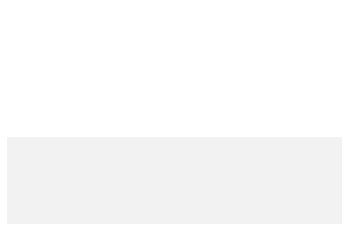

In [19]:
up.add_stacked_bars('Truth', sum_over='Count', elements=6)
print(up._subset_plots)
up._subset_plots.pop(0)
f = plt.figure()
up.plot_shading(plt.axes())

In [20]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(group_data['SNP'])

Count  Truth
NEB   Nextera Swift2S Quanta Kapa                 
True  True    True    True   True   1580858   True
                             False   133277   True
                      False  True    131415   True
                             False    67315   True
              False   True   True    129455   True
                             False    66410   True
                      False  True     65440   True
                             False    41094   True
      False   True    True   True    147077   True
                             False    72639   True
                      False  True     71803   True
                             False    43359   True
              False   True   True     70201   True
                             False    42461   True
                      False  True     41781   True
                             False    34616   True
False True    True    True   True    126872   True
                             False    65029   True
                      False  True     64716   True
                             False    41077   True
              False   True   True     63783   True
                             False    41333   True
                      False  True     40615   True
                             False    41125   True
      False   True    True   True     67376   True
                             False    40848   True
                      False  True     40584   True
                             False    33304   True
              False   True   True     39943   True
                             False    34099   True
                      False  True     32875   True
                             False   107460   True
True  True    True    True   True        88  False
                             False       15  False
                      False  True        12  False
                             False        8  False
              False   True   True         8  False
                             False        9  False
                      False  True        11  False
                             False       18  False
      False   True    True   True        12  False
                             False        7  False
                      False  True        14  False
                             False       20  False
              False   True   True        17  False
                             False       23  False
                      False  True        32  False
                             False       58  False
False True    True    True   True        13  False
                             False        5  False
                      False  True         8  False
                             False       15  False
              False   True   True        10  False
                             False       20  False
                      False  True        16  False
                             False       37  False
      False   True    True   True         4  False
                             False        6  False
                      False  True        28  False
                             False       57  False
              False   True   True        23  False
                             False       62  False
                      False  True        79  False
                             False  1747598  False

In [21]:
group_combinations[(True,'SNP')].sum()

3620240

### Normal plot for true/false positives separately

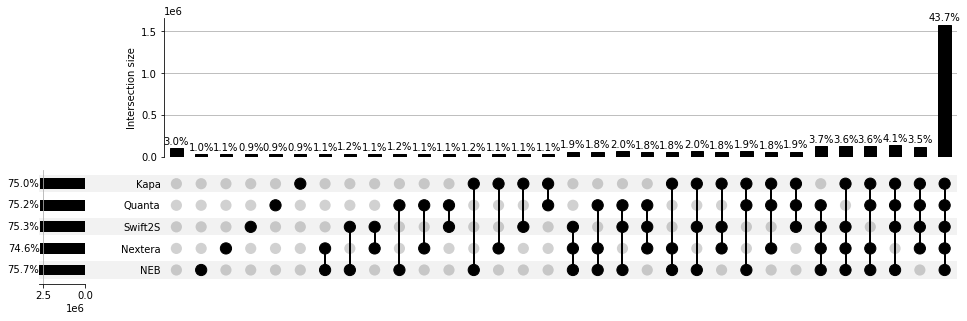

In [22]:
up = upsetplot.UpSet(group_combinations[(True,'SNP')], sort_by='degree', sort_categories_by=None, show_percentages=True)
frames = up.plot()
#frames['intersections'].set_ylim(0, group_combinations[(True, 'SNP')][(False, True, True, True, True)] * 1.1)

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

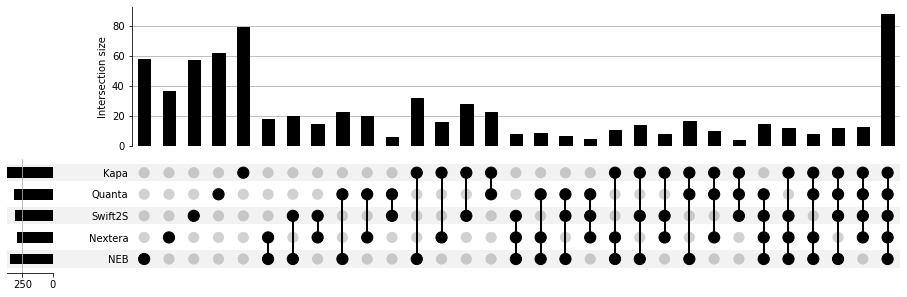

In [23]:
upsetplot.plot(group_combinations[(False,'SNP')].drop(tuple([0]*len(kits))), sort_by='degree', sort_categories_by=None)

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

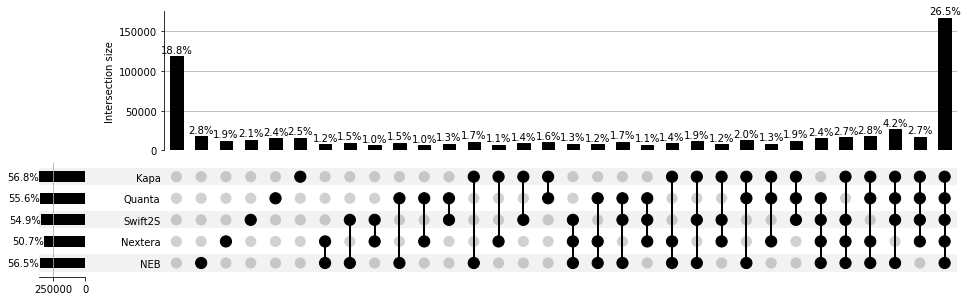

In [24]:
upsetplot.plot(group_combinations[(True, 'INDEL')], sort_by='degree', sort_categories_by=None, show_percentages=True)

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

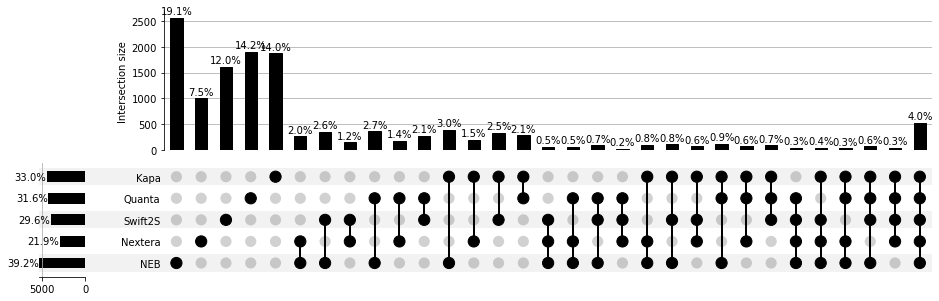

In [25]:
upsetplot.plot(group_combinations[(False, 'INDEL')].drop(tuple([0]*len(kits))), sort_by='degree', sort_categories_by=None, show_percentages=True)

## Test / experimenting

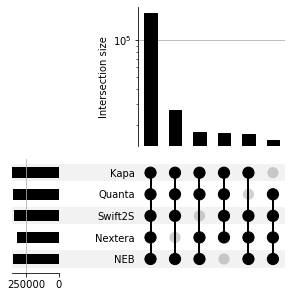

In [26]:
subplots = upsetplot.plot(group_combinations[(True, 'INDEL')].drop(tuple([0]*len(kits))), sort_by='cardinality', sort_categories_by=None, min_degree=4)
subplots['intersections'].set_yscale('log')

In [27]:
intra_kit_consensus

{'NEB': [152593, 293461, 709395, 1136806, 1958873],
 'Nextera': [153423, 325257, 752924, 1154432, 1865092],
 'Swift2S': [149667, 303008, 724625, 1153061, 1920767],
 'Quanta': [143161, 303874, 731418, 1157505, 1915170],
 'Kapa': [147532, 302427, 728025, 1149480, 1923664]}

In [28]:
kit_numreplicates_trueposcount = [
    (kit, num_replicates_called, intra_kit_consensus[kit][num_replicates_called])
    for num_replicates_called in [0,1,2,3,4]
    for kit in kits
]

In [29]:
iccdf = pd.DataFrame(data=kit_numreplicates_trueposcount, columns=['Kit', 'NumReplicatesHave', 'NumTpCalls'])

<AxesSubplot:xlabel='NumReplicatesHave', ylabel='NumTpCalls'>

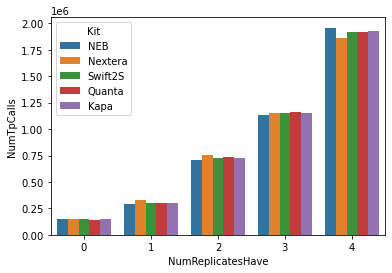

In [30]:
sns.barplot(data=iccdf, x='NumReplicatesHave', y='NumTpCalls', hue='Kit')

## Export data to csv

In [31]:
dataframes = []
for (truth, typ) in [(True, 'SNP'), (True, 'INDEL'), (False, 'SNP'), (False, 'INDEL')]:
    part_df = group_combinations[(truth, typ)].reset_index().rename(columns={0: 'Count'})
    part_df['Truth'] = truth
    part_df['Type'] = typ
    dataframes.append(part_df)
full_df = pd.concat(dataframes)
# Uncomment this to write / overwrite the file
#full_df.to_csv('overlap-variant-data.csv', index=False)
full_df.head(n=1)

,NEB,Nextera,Swift2S,Quanta,Kapa,Count,Truth,Type
0,True,True,True,True,True,1580858,True,SNP


# Load exported data

In [32]:
full_df = pd.read_csv('overlap-data-all-d.csv')
group_combinations2 = {}
for (truth, typ) in [(True, 'SNP'), (True, 'INDEL'), (False, 'SNP'), (False, 'INDEL')]:
    part_df = full_df.loc[(full_df.Type==typ)&(full_df.Truth==truth)].set_index(kits)
    group_combinations2[(truth, typ)] = part_df.Count

print(group_combinations2[(True, 'SNP')].head(n=1))

NEB   Nextera  Swift2S  Quanta  Kapa
True  True     True     True    True    1508856
Name: Count, dtype: int64


In [33]:
# Uncomment this to load from file 
#group_combinations = group_combinations2

# Testing / Experiment

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>,
 'extra1': <AxesSubplot:>}

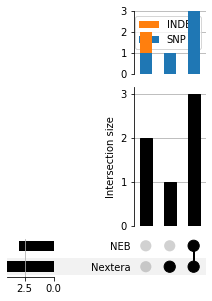

In [34]:
løk = pd.DataFrame(
    {
        #'Kit': ['Nextera', 'NEB', 'Nextera', 'NEB', 'Nextera', 'NEB'],
        'Nextera': [True, True, True, False, False, True],
        'NEB':   [ False, True, True, False, False, True],
        'Type':  ['SNP','SNP','SNP','INDEL','SNP','SNP']
    }
).set_index(['Nextera', 'NEB'])
up = upsetplot.UpSet(løk)
up.add_stacked_bars('Type')
up.plot()

(<Figure size 432x288 with 4 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

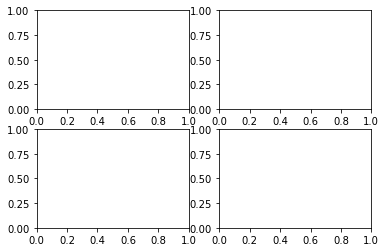

In [35]:
plt.subplots(2, 2)

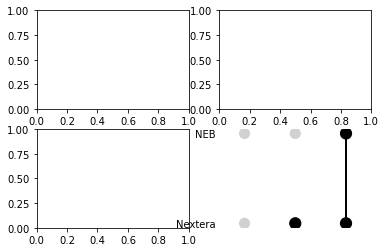

In [36]:
(fig, (tops, bots)) = plt.subplots(2, 2)
up2 = upsetplot.UpSet(løk)
up2.plot_matrix(bots[1])
up2.add_stacked_bars('Type')

# SNP count double check with bcftools

In [37]:
af_names = list(os.path.basename(p).replace(".vcf.gz","") for p in af.Path)
print(" ".join(af_names))

Kapa-100ng-2 Kapa-100ng-3 Quanta-100ng-4 Nextera-100ng-4 NEB-100ng-4 Swift2S-100ng-4 Kapa-100ng-1 Quanta-100ng-1 NEB-100ng-2 Nextera-100ng-2 Swift2S-100ng-2 NEB-100ng-3 Nextera-100ng-3 Swift2S-100ng-3 Quanta-100ng-3 Kapa-100ng-4 NEB-100ng-1 Quanta-100ng-2 Nextera-100ng-1 Swift2S-100ng-1


In [38]:
af['bcftoolsTpCount'] = [int(open(f"tmp-snpcounts/tp-{n}.txt").read().strip()) for n in af_names]
af['bcftoolsFpCount'] = [int(open(f"tmp-snpcounts/fp-{n}.txt").read().strip()) for n in af_names]
print(af.groupby("Kit").bcftoolsTpCount.sum())
print(af.groupby("Kit").bcftoolsFpCount.sum())
print(af.groupby("Kit").apply(lambda row: row.bcftoolsTpCount.sum() / (row.bcftoolsTpCount.sum() + row.bcftoolsFpCount.sum())))

Kit
Kapa       11307706
NEB        11369126
Nextera    11269522
Quanta     11323633
Swift2S    11335724
Name: bcftoolsTpCount, dtype: int64
Kit
Kapa       762561
NEB        780919
Nextera    612778
Quanta     789537
Swift2S    843675
Name: bcftoolsFpCount, dtype: int64
Kit
Kapa       0.936823
NEB        0.935727
Nextera    0.948429
Quanta     0.934820
Swift2S    0.930729
dtype: float64
